### Preprocess sci-plex data

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.io as io
import seaborn as sns
import matplotlib.pyplot as plt

In [28]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
data_path = '/data_volume/memento/sciplex/'

### Assemble sci-plex data

In [4]:
genes = pd.read_csv(
    data_path + 'raw/GSM4150378_sciPlex3_A549_MCF7_K562_screen_gene.annotations.txt', 
    index_col=0,
    sep=' ')
var_df = pd.DataFrame(index=genes['gene_short_name'])
var_df['gene_id'] = genes.index.values

In [5]:
cells = pd.read_csv(
    data_path + 'raw/GSM4150378_sciPlex3_pData.txt', 
    index_col=0,
    sep=' ')
# obs_df = pd.DataFrame(index=cells['0'])
# obs_df['cell'] = cells['0'].tolist()

In [6]:
print('gene', genes.shape)
print('cell', cells.shape)

gene (110983, 1)
cell (799317, 39)


In [7]:
# Takes a very long time to read
a = io.mmread(data_path + '/raw/formatted_UMI_count.matrix')

In [8]:
adata = sc.AnnData(X=a.T.tocsr(), obs=cells, var=var_df)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [9]:
adata.write(data_path + 'h5ad/sciplex.h5ad')

... storing 'sample' as categorical
... storing 'top_oligo_W' as categorical
... storing 'top_oligo_P' as categorical
... storing 'pcr_well' as categorical
... storing 'pcr_plate' as categorical
... storing 'culture_plate' as categorical
... storing 'Combo' as categorical
... storing 'well_oligo' as categorical
... storing 'plate_oligo' as categorical
... storing 'cell_type' as categorical
... storing 'replicate' as categorical
... storing 'drug_dose' as categorical
... storing 'catalog_number' as categorical
... storing 'treatment' as categorical
... storing 'pathway_level_1' as categorical
... storing 'pathway_level_2' as categorical
... storing 'product_name' as categorical
... storing 'target' as categorical
... storing 'pathway' as categorical


### Filter  and subset the sci-plex data

also, do some sanity checks if the file was correctly loaded....

In [10]:
adata = sc.read(data_path + 'h5ad/sciplex.h5ad')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [11]:
adata.var_names_make_unique()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/utils.py:111: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD113-1', 'SNORD113-2', 'SNORD113-3', 'SNORD113-4', 'SNORD113-5']
  warnings.warn(


In [12]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [13]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

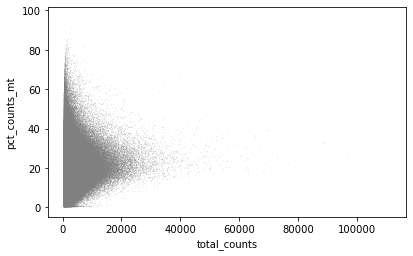

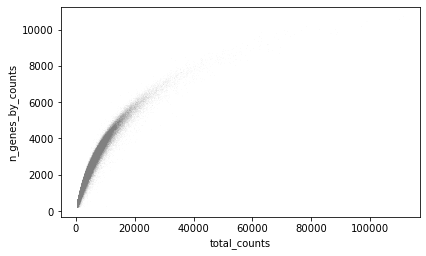

In [14]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', size=1)
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [15]:
adata = adata[adata.obs.n_genes_by_counts < 8000, :]
adata = adata[adata.obs.pct_counts_mt < 50, :]

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


### Create a cell type and HDAC subsets

In [16]:
adata.obs.vehicle.value_counts()

False    776181
True      17503
Name: vehicle, dtype: int64

In [18]:
adata_dict = {}
cell_types = ['MCF7', 'A549', 'K562']
for ct in cell_types:
    
    adata_ct = adata[adata.obs.cell_type==ct]
    adata_ct.write(data_path + 'h5ad/{}.h5ad'.format(ct))
    adata_ct_hdac = adata_ct[(adata_ct.obs.target == 'HDAC') | adata_ct.obs.vehicle]
    adata_ct_hdac.write(data_path + 'h5ad/{}_HDAC.h5ad'.format(ct))
    
    print(ct, adata_ct.shape, adata_ct_hdac.shape)

MCF7 (343939, 65090) (52041, 65090)
A549 (242144, 65090) (43056, 65090)
K562 (172460, 65090) (22037, 65090)


### Create big buckets for analysis

In [42]:
df = adata_ct.obs.copy()
df['pathway_level_2'] = df['pathway_level_2'].astype(str)
df['target'] = df['target'].astype(str)
df['product_name'] = df['product_name'].astype(str)

In [50]:
multidrug_targets = df.drop_duplicates(['product_name']).groupby('target').size()
multidrug_targets = multidrug_targets[multidrug_targets > 3]

In [52]:
multidrug_targets.index.tolist()

['Aurora Kinase',
 'DNA/RNA Synthesis',
 'HDAC',
 'Histone Methyltransferase',
 'JAK',
 'PARP',
 'Sirtuin']

In [45]:
df.groupby(['target', 'product_name']).size()

target                                                     product_name                                
ALK,c-Met                                                  Crizotinib (PF-02341066)                         753
AMPK                                                       AICAR (Acadesine)                               1055
Androgen Receptor                                          Andarine                                        1019
Aromatase                                                  Aminoglutethimide                               1119
Aurora Kinase                                              AMG-900                                          845
                                                           Alisertib (MLN8237)                              631
                                                           Aurora A Inhibitor I                             954
                                                           Barasertib (AZD1152-HQPA)                        738


In [30]:
adata_ct.obs.drop_duplicates(['target', 'product_name']).groupby(['target']).product_name.count()

target
ALK,c-Met                                                     1
AMPK                                                          1
Androgen Receptor                                             1
Aromatase                                                     1
Aurora Kinase                                                13
Aurora Kinase,Bcr-Abl,FLT3                                    1
Aurora Kinase,Bcr-Abl,JAK                                     1
Aurora Kinase,Bcr-Abl,c-RET,FGFR                              1
Aurora Kinase,CDK                                             1
Aurora Kinase,FLT3,VEGFR                                      2
Aurora Kinase,VEGFR                                           1
Autophagy,ROCK                                                1
Autophagy,Sirtuin                                             1
Bcl-2                                                         3
Bcr-Abl                                                       1
Bcr-Abl,c-Kit,Src                

In [26]:
adata_ct.obs.groupby(['target']).product_name.value_counts()

target                     product_name                      
ALK,c-Met                  Crizotinib (PF-02341066)               753
AMPK                       AICAR (Acadesine)                     1055
Androgen Receptor          Andarine                              1019
Aromatase                  Aminoglutethimide                     1119
Aurora Kinase              Aurora A Inhibitor I                   954
                                                                 ... 
c-Met,IGF-1R,Trk receptor  BMS-754807                            1022
c-Met,Tie-2,VEGFR          Glesatinib?(MGCD265)                   953
c-RET,FLT3,JAK             TG101209                               808
c-RET,VEGFR                Regorafenib (BAY 73-4506)              801
mTOR                       Temsirolimus (CCI-779, NSC 683864)     796
Name: product_name, Length: 189, dtype: int64

### Create pseudotime for each of the cell types for HDAC inhibitors

LOLOL Use UMAP1 as pseudodose....

In [ ]:
ct = 'A549'

In [ ]:
adata = sc.read(data_path + 'h5ad/{}_HDAC.h5ad'.format(ct))

In [ ]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata.raw = adata
adata = adata[:, adata.var.highly_variable]



In [ ]:
adata.uns['iroot'] = np.flatnonzero(adata.obs['vehicle']  == True)[0]


In [ ]:
sc.pp.neighbors(adata, n_neighbors=500, n_pcs=20)
sc.tl.umap(adata)
sc.tl.diffmap(adata)


In [ ]:
adata.obs.head(5)

In [ ]:
adata.obs['is_vehicle'] = adata.obs.vehicle.apply(lambda x: 'vehicle' if x else 'HDAC').astype('category')

In [ ]:
adata.obs['sample'].value_counts()

In [ ]:
adata.obs['pseudodose'] = adata.obsm['X_umap'][:, 1]

In [ ]:
plt.figure(figsize=(3,4))
sns.boxplot(y='pseudodose', x='dose', data=adata.obs)

In [ ]:
max_dose_df = adata.obs.query('dose > 9000')

In [ ]:
max_dose_df.pseudodose.min()

In [ ]:
doses = adata.obs.dose.value_counts()

In [ ]:
for drug in max_dose_df.product_name.drop_duplicates():
    
    plt.figure()
    for dose in [0, 10, 100, 1000, 10000]:
        sns.kdeplot(adata.obs.query('product_name == "{}" & dose == {}'.format(drug, dose)).pseudodose)
    plt.xlim(-8, 8)
    plt.title(drug)